In [1]:
import cv2
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

from PIL import Image
from pylab import array, plot, show, axis, arange, figure, uint8 

from pytesseract import image_to_string
import pytesseract

In [2]:
print(cv2.__version__)

4.2.0


In [3]:
cars = []
for i in range(5):
    cars.append('car'+'_'+str(i+1)+'.jpg')

In [4]:
image = cv2.imread(cars[3])
carro = image.copy()
carro = cv2.resize(carro,(468, 280))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [5]:
def plot_images(img1, img2, title1="", title2=""):
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)

    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)

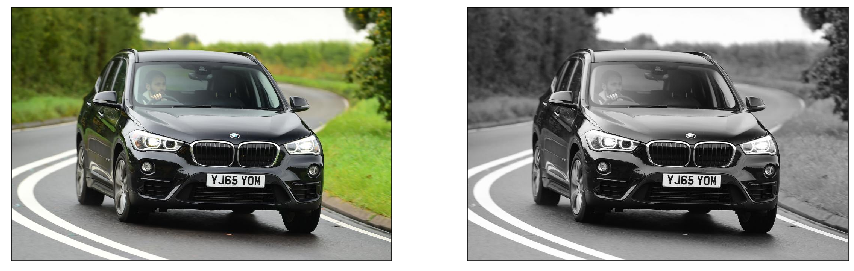

In [6]:
plot_images(image, gray)

In [7]:
blur = cv2.bilateralFilter(gray, 11,90, 90)

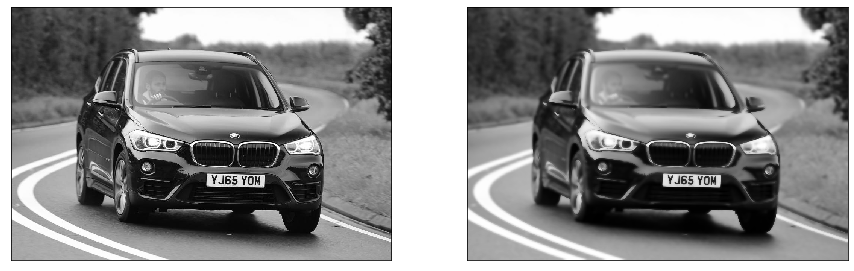

In [8]:
plot_images(gray, blur)

In [9]:
edges = cv2.Canny(blur, 30, 200)

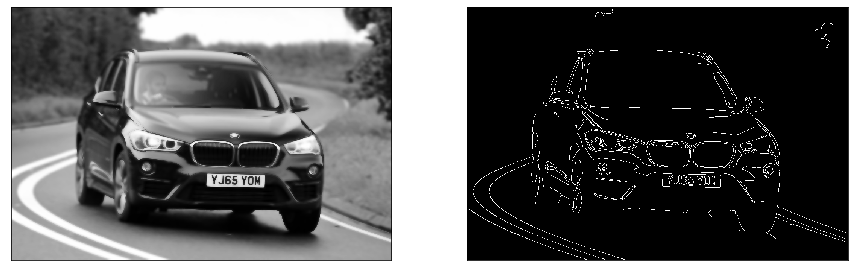

In [10]:
plot_images(blur, edges)

In [11]:
cnts, new = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [12]:
image_copy = image.copy()

In [13]:
_ = cv2.drawContours(image_copy, cnts, -1, (44,225,207),2)

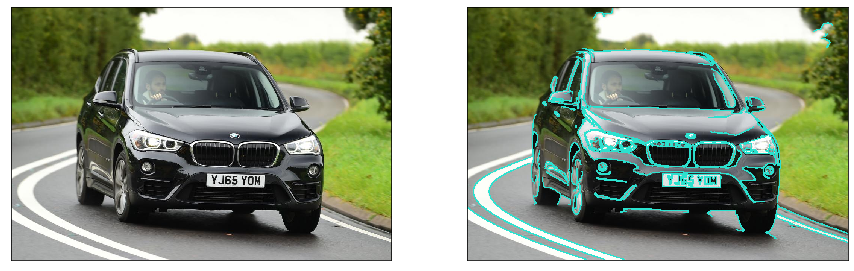

In [14]:
plot_images(image, image_copy)

In [15]:
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:30]

In [16]:
image_copy = image.copy()
_ = cv2.drawContours(image_copy, cnts, -1, (44,225,207),2)

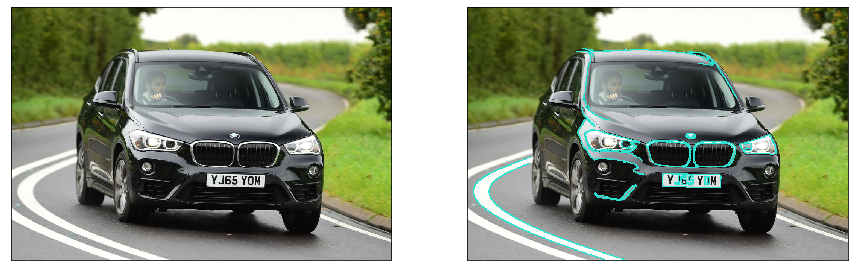

In [17]:
plot_images(image, image_copy)

In [18]:
plate = None
for c in cnts:
    perimeter = cv2.arcLength(c, True)
    edges_count = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    if len(edges_count) == 4:
        x,y,w,h = cv2.boundingRect(c)
        plate = image[y:y+h, x:x+w]
        break

In [19]:
def pad_width(vector, pad_width, iaxis, kwargs):
        pad_value = kwargs.get('padder', 10)
        vector[:pad_width[0]] = pad_value
        vector[-pad_width[1]:] = pad_value

k = 2
kernel = np.ones((k,k),np.float32)/(k*k)

k = 100
img = plate.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = np.pad(img, math.floor(k/2), pad_width, padder = 255)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

k = 3
kernel = np.ones((k, k), np.uint8)

img = cv2.erode(img,kernel,iterations=1)
img = cv2.dilate(img,kernel,iterations=1)
img = cv2.erode(img,kernel,iterations=1)
img = cv2.dilate(img,kernel,iterations=1)

phi = 1;theta = 1;maxIntensity = 255.0;img = (maxIntensity/phi)*(img/(maxIntensity/theta))**1.5;img = array(img,dtype=uint8)

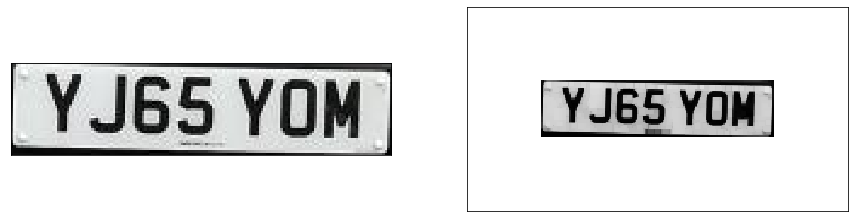

True

In [20]:
fig = plt.figure(figsize=[15,15])
ax1 = fig.add_subplot(121)
ax1.imshow(plate, cmap="gray")
ax1.set(xticks=[], yticks=[])

ax1 = fig.add_subplot(122)
ax1.imshow(img, cmap="gray")
ax1.set(xticks=[], yticks=[])
plt.show()

cv2.imwrite("plate.png", img)

In [21]:
text = pytesseract.image_to_string(plate, lang="eng")
text = ''.join(c for c in text if c.isupper() or c.isdigit() or c == ' ')

# Perfom Model

In [22]:
# Import the modules
import cv2
import joblib
from skimage.feature import hog
import numpy as np


# Load the classifier

im = cv2.imread("plate.PNG")
image = Image.open('plate.PNG')
im = image.resize((carro.shape[1], carro.shape[0]))
im = np.array(im) 
im = im[:, :, ::-1].copy()

# Convert to grayscale and apply Gaussian filtering
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

# Threshold the image
ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

# Find contours in the image
ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get rectangles contains each contour
rects = [cv2.boundingRect(ctr) for ctr in ctrs]

# For each rectangular region, calculate HOG features and predict
# the digit using Linear SVM.

for rect in rects:
    # Draw the rectangles
    cv2.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 0, 255), 3) 
    # Make the rectangular region around the digit
    leng = int(rect[3] * 1.6)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]
    # Resize the image
    try:
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = cv2.dilate(roi, (3, 3))
        # Calculate the HOG features
        roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=False)
        
    except:
        print('Not possible')

cv2.putText(im, text, (rect[0], rect[1]),cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 2)
# cv2.imshow('car_1.png', carro)
# cv2.imshow("Resulting Image with Rectangular ROIs", im)
cnct = np.concatenate((carro, im),axis=1)
cv2.imshow('Result',cnct)
cv2.waitKey()

-1